<a href="https://colab.research.google.com/github/emiliomercuri/MACC/blob/main/codes/Modelo_Kaczmarski%2BSzukievicz_UPDF_fluido%2Bpellet_v06(curva_ruptura).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Método numérico de solução do reator de captura de CO2

#### Modelo acoplado considerando as equações do Fluido intersticial e dos Pellets empacotados

Baseado nos artigos:

* Kaczmarski, K., & Szukiewicz, M. K. (2021). An efficient and robust method for numerical analysis of a dead zone in catalyst particle and packed bed reactor. Engineering Reports, 3(8), e12370.

* Chen-Charpentier, B. M., & Kojouharov, H. V. (2013). An unconditionally positivity preserving scheme for advection–diffusion reaction equations. Mathematical and computer modelling, 57(9-10), 2177-2185.


Variáveis:
* $y_i^{n}$: Concentração de CO$_2$ na fase gasosa (função de x e t)
* $c_{j,i}^{n}$: Concentração de CO$_2$ nos Pellets (fase sólida) (função de R, x e t)

Índices:
* $n$ - tempo $t$
* $i$ - posição axial $x$ do reator
* $j$ - posição radial $R$ dentro do Pellet

\begin{equation}
 	y_i^{n+1}
 	=
 	\frac{
 	\widehat{\rm Pe}  \, y_{i+1}^n +
 	y_i^n  / \Delta t  +
 	\left( 1 / \Delta x   +
 	\widehat{\rm Pe}    \right)  y_{i-1}^n  +
 	A  \, c_{i,j}^n
 	}{
 	1 / \Delta t +
 	1 / \Delta x +
 	2 \widehat{\rm Pe}   +
 	A }
\end{equation}


Condições de contorno (em $x$ temos os índices $i = 0...m$):

* $y_{0}^{n} = y_f$ e $y_1^{n} = y_f$
* $y_m^{n} = y_{m-1}^{n}$


\begin{equation}
 	c_{j,i}^{n+1}
 	=
 	\frac{
 	\left( \frac{\Delta R \, \Delta t \, E}{R_d+ F R_j}  +
 	\Delta t \, B
 	\right) c_{j+1,i}^{n} +
 	\Delta R^2 c_{j,i}^n +
 	\Delta t \, B \, c_{j-1,i}^n
 	}{
 	\left(
 	\Delta R^2 +
 	\frac{\Delta R \, \Delta t \, E}{R_d+ F R_j} +
 	2 \Delta t \, B +
 	\Delta R^2 \, \Delta t \, G
 	\right)
 	}
 \end{equation}

Condições de contorno (em $R$ temos os índices $j = 0...k$):

*	$c_{k,i}^{n}   = (\mathrm{Bi} \, \Delta R \,  y_{i}^{n}  + c_{k-1,i}^n ) / (1 + \mathrm{Bi} \, \Delta R )$
* $c_{0,i}^{n} = c_{1,i}^n$



In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from numpy import zeros, linspace

In [2]:
# Condição inicial para y (gás) e c (pellet)
y0 = 0
c0 = 0

# Velocidade média do escoamento no leito do reator
u = 1 # m/s Referência ??

# Coeficiente de Dispersão
D_L = 10.0 # 0.0000138 # m2/s Referência Cussler (2000) Tabela 4.A.2: D_difusão_CO2 = 0.138 cm2 s-1 ou 0.177 cm2 s-1

# Coeficiente de Difusão Efetivo (Está faltando explicar o que é Dm no artigo de Kaczmarski Szukievicz)
Deff = 10.0

# Porosidade aparente
epsilon_e = 0.4 # Referência ??

# Porosidade da partícula
epsilon_p = 0.3 # Referência ??

# coeficiente de transferência de massa externa
k_ext = 10.0

# taxa da reação cinética
k_rea = 100000.0

# Raio da Partícula
Rp = 0.01 # m (ou 1 cm) isso é razoável?

# Raio da zona morta
Rd = 0

# geometria da partícula que pode ser esférica, cilíndrica ou uma placa (2, 1 ou 0, respectivamente)
alpha = 2 # (esfera)

# constante
a_p = (alpha + 1)/Rp

In [3]:
dx = 0.02
dr = 0.1
dt = 0.004
T = 50.0
L = 1.0
R = 1.0
nx = int(L/dx)    # L = tamanho do domínio no espaço
nt = int(T/dt)     # T = tamanho do domínio no tempo
nr = int(R/dr)    # R = raio adimensional do pellet

\begin{equation}
 	y_i^{n+1}
 	=
 	\frac{
 	\widehat{\rm Pe}  \, y_{i+1}^n +
 	y_i^n  / \Delta t  +
 	\left( 1 / \Delta x   +
 	\widehat{\rm Pe}    \right)  y_{i-1}^n  +
 	A \, y_p
 	}{
 	1 / \Delta t +
 	1 / \Delta x +
 	2 \widehat{\rm Pe}   +
 	A }
\end{equation}

In [4]:
# Número de Peclet
Pe = u*L/(D_L*epsilon_e)

# Número de Peclet chapeu
Pe_c = 1/(Pe*dx**2)

# Número de Stanton
St = k_ext*a_p*L*epsilon_e/u

# Constante
A = St*(1-epsilon_e)/epsilon_e

# Número de Biot
Bi = k_ext*Rp/Deff

# Módulo de Thiele ao quadrado
phi2 = (Rp**2)*k_rea/Deff

In [5]:
c = zeros((nt+1,nr+1,nx+1),float)
y = zeros((nt+1,nx+1),float)
y
#c

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
x = linspace(0.0,L,nx+1)
print(len(x))
print(x)

51
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


In [7]:
r = linspace(0.0,R,nr+1)
len(r)
r

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [8]:
t = linspace(0.0,T,nt+1)
len(t)

12501

\begin{equation}
 	y_i^{n+1}
 	=
 	\frac{
 	\widehat{\rm Pe}  \, y_{i+1}^n +
 	y_i^n  / \Delta t  +
 	\left( 1 / \Delta x   +
 	\widehat{\rm Pe}    \right)  y_{i-1}^n  +
 	A \, y_p
 	}{
 	1 / \Delta t +
 	1 / \Delta x +
 	2 \widehat{\rm Pe}   +
 	A }
\end{equation}

In [9]:
# Concentração do fluido de entrada
y_f = 0.1

Variáveis auxiliares:

* $B = \frac{1}{\varepsilon_p} \frac{ \mathrm{St}}{(\alpha+1) \mathrm{Bi}} \frac{R_p^2}{\left(R_p-R_d\right)^2} $
* $E = \frac{1}{\varepsilon_p} \frac{ \mathrm{St}}{(\alpha+1) \mathrm{Bi}}  \alpha\left(R_p-R_d\right)  \frac{R_p^2}{\left(R_p-R_d\right)^2}	= B \alpha\left(R_p-R_d\right)$
* $F = \left(R_p-R_d\right)$
* $G = \frac{\left(1-\varepsilon_p\right)}{\varepsilon_p}  \frac{\Phi^2 \mathrm{St}}{(\alpha+1) \mathrm{Bi}}$

In [10]:
B = St*Rp**2 / (epsilon_p * (alpha+1) * Bi * (Rp-Rd)**2)
E = B * alpha * (Rp-Rd)
F = (Rp-Rd)
G = (1-epsilon_p) * phi2 * St / (epsilon_p * (alpha+1) * Bi)

NOVA Variável auxiliar:

* $Z_i = (\Delta R \, \Delta t \, E) / (R_d+ F \, r_j)$

\begin{equation}
 	c_{j,i}^{n+1}
 	=
 	\frac{
 	\left( Z_i  +
 	\Delta t \, B
 	\right) c_{j+1,i}^{n} +
 	\Delta R^2 c_{j,i}^n +
 	\Delta t \, B \, c_{j-1,i}^n
 	}{
 	\left(
 	\Delta R^2 +
 	Z_i +
 	2 \Delta t \, B +
 	\Delta R^2 \, \Delta t \, G
 	\right)
 	}
 \end{equation}

Condições de contorno (em $R$ temos os índices $j = 0...k$):

*	$c_{k,i}^{n}   = (\mathrm{Bi} \, \Delta R \,  y_{i}^{n}  + c_{k-1,i}^n ) / (1 + \mathrm{Bi} \, \Delta R )$
* $c_{0,i}^{n} = c_{1,i}^n$


In [11]:
for n in range(nt-1):
    tn = n*dt
    # condições de contorno para y (CO2 no gas)
    y[n,0] = y_f
    y[n,1] = y_f
    y[n,nx] = y[n,nx-1]
    for i in range(1,nx):
        xi = i*dx
        y[n+1,i] = (Pe_c*y[n,i+1]+y[n,i]/dt+(1/dx+Pe_c)*y[n,i-1]+A*c[n,nr,i])/(1/dt+1/dx+2*Pe_c+A)
        # condições de contorno para c (CO2 no pellet)
        c[n,0,i] = c[n,1,i]
        c[n,nr,i] = (Bi*dr*y[n,i] + c[n,nr-1,i])/(1+Bi*dr)
        for j in range(1,nr):
          ri = j*dr
          Zi = (dr * dt * E) / (Rd + F * ri)
          c[n+1,j,i] = ((Zi+dt*B) * c[n,j+1,i] + (dr**2) * c[n,j,i] + dt * B * c[n,j-1,i]) / (dr**2 + Zi + 2*dt*B + (dr**2)*dt*G)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

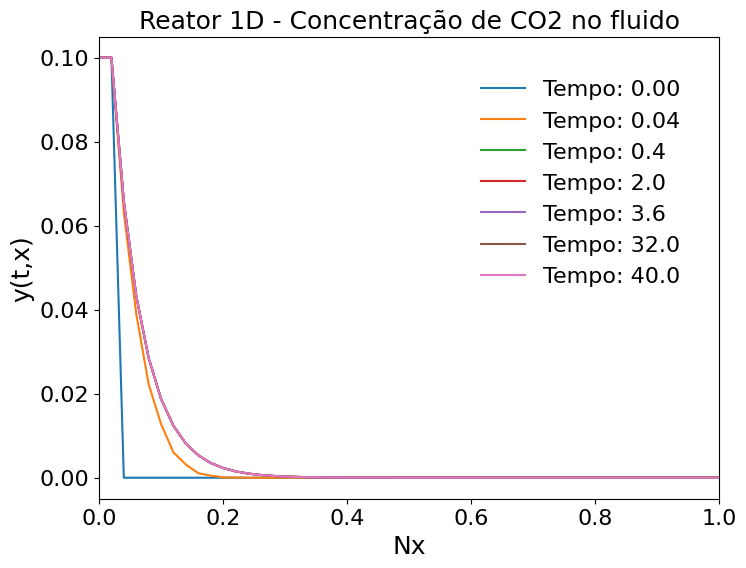

In [13]:
plt.figure(figsize=(8, 6))

plt.xlim([0,1])
#plt.ylim([0,2.0])
plt.title('Reator 1D - Concentração de CO2 no fluido', fontsize=18)
plt.xlabel('Nx', fontsize=18)
plt.ylabel('y(t,x)', fontsize=18)
plt.tick_params(axis='both', labelsize=16) #increase font size for ticks


plt.plot(x,y[0,:], label="Tempo: 0.00")
#plt.plot(x,y[1,:], label="Tempo: "+str(t[1]))
#plt.plot(x,y[3,:], label="Tempo: "+str(t[3]))
plt.plot(x,y[10,:], label="Tempo: "+str(t[10]))
#plt.plot(x,y[50,:], label="Tempo: "+str(t[50]))
#plt.plot(x,y[80,:], label="Tempo: "+str(t[80]))
plt.plot(x,y[100,:], label="Tempo: "+str(t[100]))
plt.plot(x,y[500,:], label="Tempo: "+str(t[500]))
#plt.plot(x,y[900,:], label="Tempo: "+str(t[900]))
plt.plot(x,y[900,:], label="Tempo: "+str(t[900]))
#plt.plot(x,y[2000,:], label="Tempo: "+str(t[2000]))
plt.plot(x,y[8000,:], label="Tempo: "+str(t[8000]))
plt.plot(x,y[10000,:], label="Tempo: "+str(t[10000]))
#plt.plot(x,y[39999,:], label="Tempo: "+str(t[40000]))

plt.legend(loc="upper right",bbox_to_anchor=(0.97, 0.95), frameon=False, fontsize=16)


# Show the plot
#plt.savefig('Conc_CO2_fluido.png', dpi = 100, bbox_inches='tight')
plt.savefig('Conc_CO2_fluido.pdf', dpi = 600, bbox_inches='tight')
plt.show();

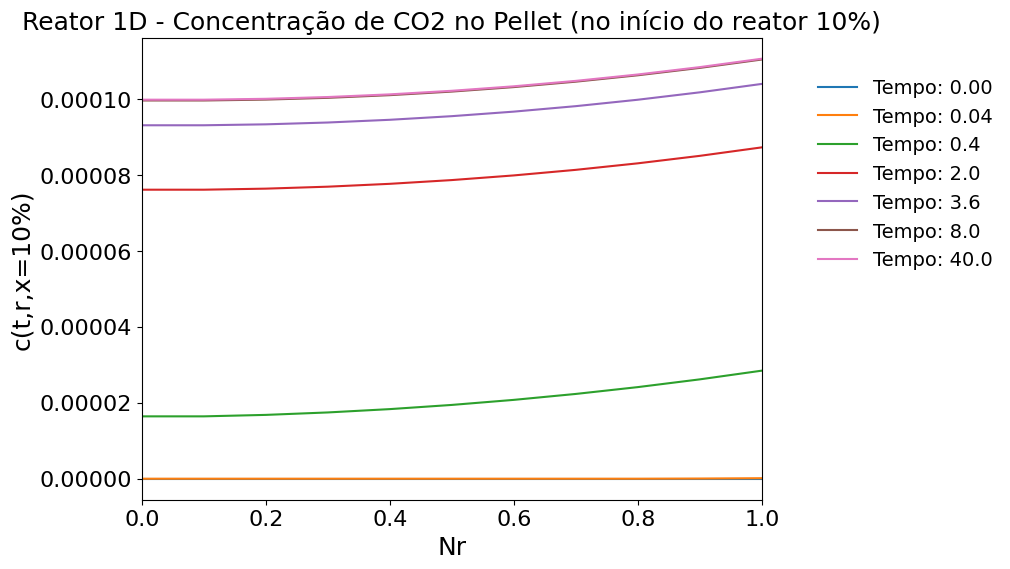

In [14]:
plt.figure(figsize=(8, 6))

plt.xlim([0,1])
#plt.ylim([0,2.0])
plt.title('Reator 1D - Concentração de CO2 no Pellet (no início do reator 10%)', fontsize=18)
plt.xlabel('Nr', fontsize=18)
plt.ylabel('c(t,r,x=10%)', fontsize=18)
plt.tick_params(axis='both', labelsize=16) #increase font size for ticks


plt.plot(r,c[0,:,10], label="Tempo: 0.00")
plt.plot(r,c[10,:,10], label="Tempo: "+str(t[10]))
plt.plot(r,c[100,:,10], label="Tempo: "+str(t[100]))
plt.plot(r,c[500,:,10], label="Tempo: "+str(t[500]))
plt.plot(r,c[900,:,10], label="Tempo: "+str(t[900]))
plt.plot(r,c[2000,:,10], label="Tempo: "+str(t[2000]))
plt.plot(r,c[10000,:,10], label="Tempo: "+str(t[10000]))
#plt.plot(r,c[39998,:,10], label="Tempo: "+str(t[40000]))
#plt.legend(loc='best');

plt.legend(loc="upper right",bbox_to_anchor=(1.4, 0.95), frameon=False, fontsize=14)

# Show the plot
#plt.savefig('Conc_CO2_pellet.png', dpi = 100, bbox_inches='tight')
plt.savefig('Conc_CO2_pellet.pdf', dpi = 600, bbox_inches='tight')
plt.show();

### Curva de Ruptura

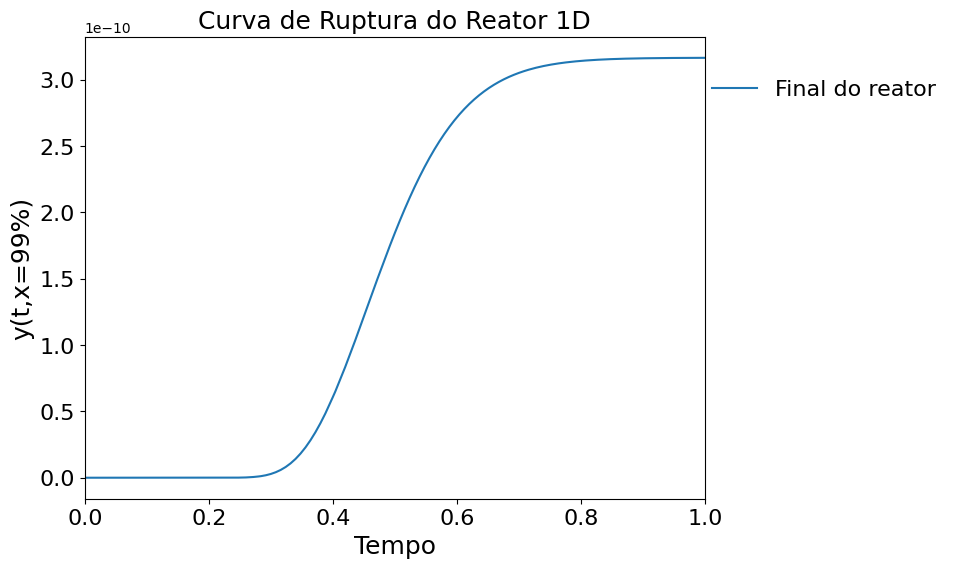

In [15]:
plt.figure(figsize=(8,6))

plt.xlim([0,1])
#plt.ylim([0,2.0])
plt.title('Curva de Ruptura do Reator 1D', fontsize=18)
plt.xlabel('Tempo', fontsize=18)
plt.ylabel('y(t,x=99%)', fontsize=18)
plt.plot(t,y[:,50], label="Final do reator")
#plt.legend(loc="upper right");
plt.tick_params(axis='both', labelsize=16) #increase font size for ticks


plt.legend(loc='best',bbox_to_anchor=(0.98, 0.95), frameon=False, fontsize=16)

# Show the plot
#plt.savefig('Curva_ruptura.png', dpi = 100, bbox_inches='tight')
plt.savefig('Curva_ruptura.pdf', dpi = 600, bbox_inches='tight')
plt.show();